## Importing Libraries

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.15.0


## Loading dataset and Visualising

- The MNIST database contains 60,000 training images and 10,000 testing images taken from American Census Bureau employees and American high school students. 
- train_images and test_images parts contain greyscale RGB codes (from 0 to 255) while train_labels and test_labels parts contains labels from 0 to 9 which represents which number they actually are. To visualize these numbers, we can get help from matplotlib.

In [2]:
# Loading
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# Defining class names
class_names = [ 'zero', 'one', 'two', 'three', 'four', 'five',
               'six', 'seven', 'eight', 'nine']

8


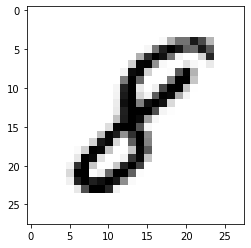

In [4]:
# Visualising
%matplotlib inline 

image_index = 7777 # You may select anything up to 60,000

print(train_labels[image_index]) # The label is 8

plt.imshow(train_images[image_index], cmap='Greys')

In [5]:
# Studying the data
print('Shape of train data: ', train_images.shape)
print('Shape of test data: ', test_images.shape)

Shape of train data:  (60000, 28, 28)
Shape of test data:  (10000, 28, 28)


- 60,000 represents the number of images in the train dataset
- (28, 28) represents the size of the image: 28 x 28 pixel.

## Reshaping the Data

That's because the first convolution expects a single tensor containing everything, so instead of 60,000 28x28x1 items in a list, we have a single 4D list that is 60,000x28x28x1, and the same for the test images. If you don't do this, you'll get an error when training as the Convolutions do not recognize the shape.

In [6]:
# reshape train data
train_images=train_images.reshape(60000, 28, 28, 1)
# reshape test data
test_images = test_images.reshape(10000, 28, 28, 1)

## Normalizing the Images

- We must normalize our data as it is always required in neural network models.
- We can achieve this by dividing the RGB codes to 255 (which is the maximum RGB code minus the minimum RGB code).

In [7]:
# Scaling train data
train_images = train_images / 255.0
# Scaling test data
test_images = test_images / 255.0

## Defining Callback

Writing an MNIST classifier that trains to 99% accuracy or above, and does it without a fixed number of epochs -- i.e. it should stop training once that level of accuracy is reached.

Some notes:
1. It should succeed in less than 10 epochs, so it is okay to change epochs= to 10, but nothing larger
2. When it reaches 99% or greater it should print out the string "Reached 99% accuracy so cancelling training!"


In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
        
callbacks = myCallback()

## Building Model

- Convolution followed with a MaxPooling layer which is then designed to compress the image, while maintaining the content of the features that were highlighted by the convlution. 
- By specifying (2,2) for the MaxPooling, the effect is to quarter the size of the image.
- The idea is that it creates a 2x2 array of pixels, and picks the biggest one, thus turning 4 pixels into 1.
- It repeats this across the image, and in so doing halves the number of horizontal, and halves the number of vertical pixels, effectively reducing the image by 25%.
- Flatten the output. After this you'll just have the same DNN structure as the non convolutional version

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

model.fit(train_images, train_labels, epochs=10, callbacks=[callbacks])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________

## Evaluating

In [10]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10000/10000 - 3s - loss: 0.0301 - acc: 0.9900

Test accuracy: 0.99


## Predicting

In [11]:
predictions = model.predict(test_images)

## Verifying Predictions

In [12]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i].reshape(28,28)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

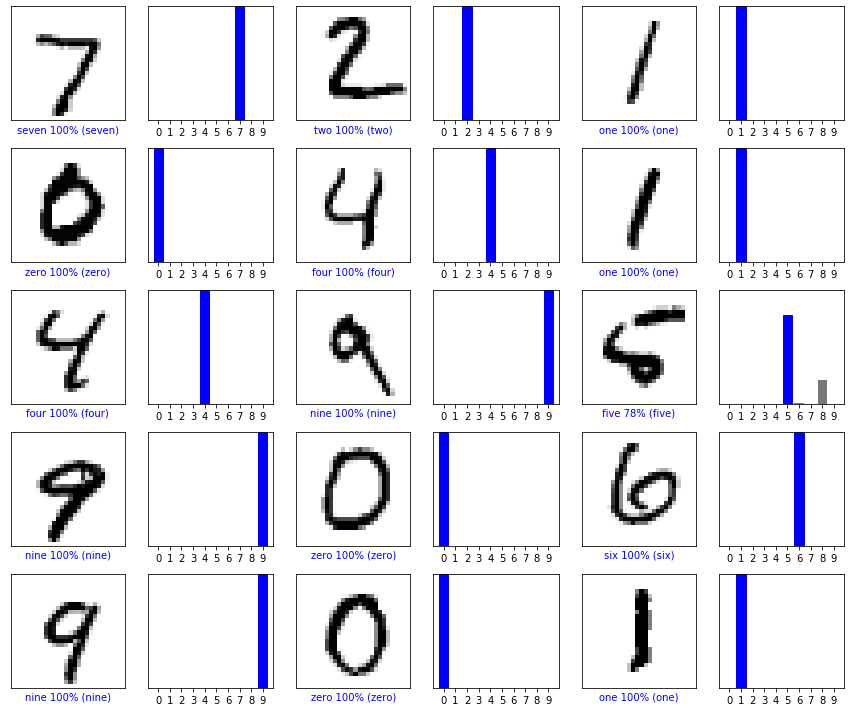

In [13]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Visualizing the Convolutions and Pooling

- This code will show us the convolutions graphically.
- The print (test_labels[;100]) shows us the first 100 labels in the test set, and you can see that the ones at 
    - index 0 
    - index 17 
    - index 26 
  are all the same value (7). They're all seven. 
- Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. 
- Now, when the DNN is training on that data, it's working with a lot less, and it's perhaps finding a commonality between seven's based on this convolution/pooling combination.

In [14]:
# checking the first 100 labels
print(test_labels[:100])

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]


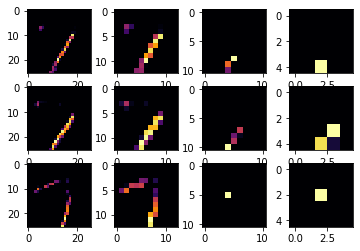

In [15]:
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=17
THIRD_IMAGE=26
CONVOLUTION_NUMBER = 1
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)